In [20]:
import numpy as np
import math
import statistics as stat
import random
import pandas as pd

from scipy.optimize import isotonic_regression
from sklearn.isotonic import IsotonicRegression
from scipy.interpolate import interp1d

from matchings import cross_bin_matching, same_bin_matching, immediate_neighbor_matching, max_weight_matching
from scipy.stats import norm
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.patches as patches


lblue = (40/255,103/255,178/255)
sgreen = (46/255,139/255,87/255)
cred = (0.69411765, 0.01568627, 0.05490196)

In [4]:
def SCINT_test(X, Y, M, nperm=500):
    Del_X = np.array([X[i]-X[j] for (i,j) in M])
    Del_Y = np.array([Y[i]-Y[j] for (i,j) in M])
    
    D_S = np.einsum('ij, j, j -> i', 
                    (np.random.rand(nperm, len(M)) < .5), 
                    Del_X, 
                    Del_Y)
    
    return (1+np.sum(D_S <= 0))/(1+nperm)

## Data setup

In [6]:
data = pd.read_csv('diabetes.csv')
data = data.dropna()
print(data.shape)
print(list(data.columns))
data.head()

(768, 9)
['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


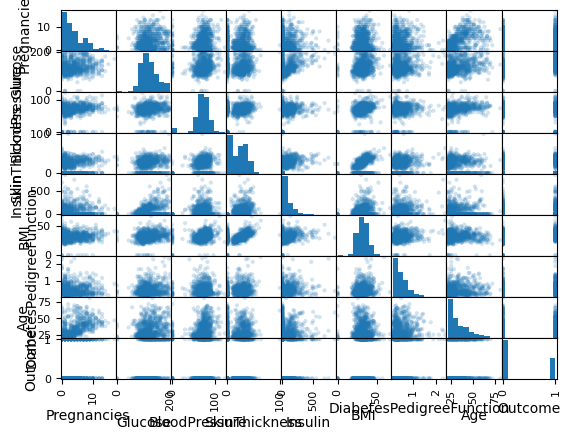

In [7]:
pd.plotting.scatter_matrix(data, alpha=0.2);

## Checking Stoch Monotonicity

<Axes: xlabel='Age', ylabel='Outcome'>

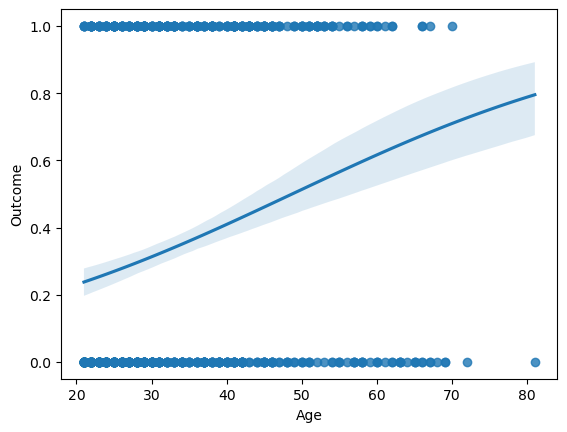

In [8]:
import seaborn as sns
sns.regplot(x=data["Age"],y=data["Outcome"], logistic=True)

## Train-test Split

In [9]:
N = data.shape[0]
Itr, Ite = np.array_split(np.random.permutation(N), 2)
ntr, nte = len(Itr), len(Ite)
train_data = data.iloc[Itr]
test_data = data.iloc[Ite]

## Run Tests

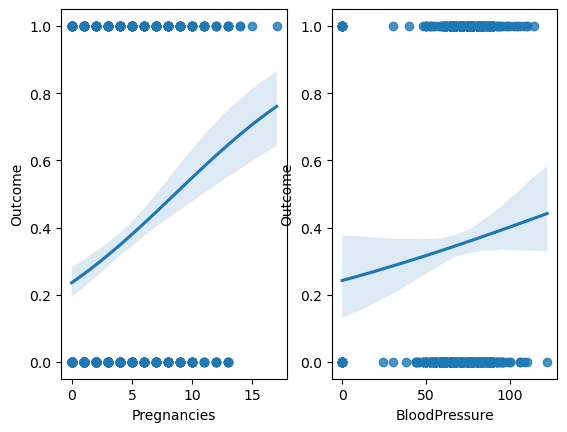

In [18]:
fig, ax = plt.subplots(1,2)
sns.regplot(x=data["Pregnancies"],y=data["Outcome"], logistic=True,ax=ax[0]);
sns.regplot(x=data["BloodPressure"],y=data["Outcome"], logistic=True,ax=ax[1]);

In [33]:
## neighbor matching
Z = np.array(test_data["Age"])
X = np.array(test_data["Outcome"])

for i in range(7):
    Y = np.array(test_data.iloc[:,i])
    M_nbhd = immediate_neighbor_matching(Y, Z)

    # fake data generation
    o = np.argsort(train_data["Age"])
    prob = isotonic_regression(train_data.Outcome[Itr[o]]).x
    f = interp1d(train_data.Age[Itr[o]], prob, kind='next', assume_sorted=True, fill_value='extrapolate')
    mu_hat = f(Z)
    X_fake = (np.random.rand(nte) <= mu_hat)*1
    
    print(list(data.columns)[i],SCINT_test(X ,Y, M_nbhd), SCINT_test(X_fake ,Y, M_nbhd), len(M_nbhd))

Pregnancies 0.34930139720558884 0.6227544910179641 75
Glucose 0.001996007984031936 0.42115768463073855 99
BloodPressure 0.2694610778443114 0.7405189620758483 91
SkinThickness 0.05389221556886228 0.8263473053892215 88
Insulin 0.001996007984031936 0.49101796407185627 67
BMI 0.001996007984031936 0.8043912175648703 107
DiabetesPedigreeFunction 0.017964071856287425 0.7405189620758483 94


In [34]:
## cross-bin matching
K = 150
Z = np.array(test_data["Age"])
X = np.array(test_data["Outcome"])

for i in range(7):
    Y = np.array(test_data.iloc[:,i])
    M_cb = cross_bin_matching(Y,Z,K)

    # fake data generation
    o = np.argsort(train_data["Age"])
    prob = isotonic_regression(train_data.Outcome[Itr[o]]).x
    f = interp1d(train_data.Age[Itr[o]], prob, kind='next', assume_sorted=True, fill_value='extrapolate')
    mu_hat = f(Z)
    X_fake = (np.random.rand(nte) <= mu_hat)*1
    
    print(list(data.columns)[i],SCINT_test(X ,Y, M_cb), SCINT_test(X_fake ,Y, M_cb), len(M_cb))

Pregnancies 0.18163672654690619 0.5768463073852296 105
Glucose 0.001996007984031936 0.6007984031936128 125
BloodPressure 0.8323353293413174 0.9500998003992016 129
SkinThickness 0.25149700598802394 0.7564870259481038 107
Insulin 0.015968063872255488 0.7345309381237525 73
BMI 0.001996007984031936 0.5608782435129741 136
DiabetesPedigreeFunction 0.003992015968063872 0.8303393213572854 131
